In [15]:
from PIL import Image
from drawing import Drawing
import os
import matplotlib.pyplot as plt
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

In [55]:
def drawing_custom_number(preprocess, filepath = './figs', return_img=True):
    if (not os.path.isdir('figs'))and (filepath == './figs'):
        os.mkdir('figs')
    draw = Drawing()
    draw.main(preprocess=preprocess,filepath=filepath)
    img = Image.open(draw.file)
    plt.imshow(img,cmap='gray')
    plt.show()
    if return_img:
        return img

file saved ./figs/7.png


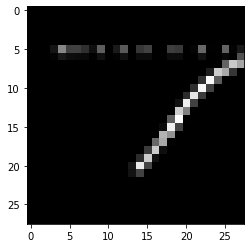

In [56]:
img = drawing_custom_number(preprocess=True,return_img=True)

In [4]:
torch.manual_seed(70)

In [7]:
train_dataset = datasets.MNIST(root ='./data',
                              train =True, 
                              download=True,
                              transform = transforms.ToTensor()) # A function that takes in an PIL image and returns a transformed version
test_dataset = datasets.MNIST(root = './data',
                             train=False,
                             transform = transforms.ToTensor())


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/home/labina/anaconda3/envs/NLB/lib/python3.8/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629395347/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


AttributeError: 'int' object has no attribute 'squeeze'

Target:
Size of image:


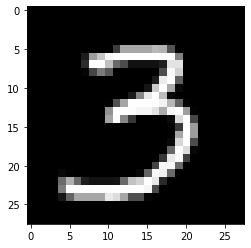

In [19]:
#just to check the datas/ among all the dataset shows selected data randomly
idx = torch.randint(0, len(train_dataset), (1,)).item()
random_image = train_dataset[idx][0].squeeze().numpy()
target_num = train_dataset[idx][1]
print('Target:'.format(target_num))
print('Size of image:'.format(random_image.shape))

plt.imshow(random_image, cmap = 'gray')
plt.axis()
plt.show()

In [22]:
#minibatch size 
batch = 64
device = 'cuda' if torch.cuda.is_available()else 'cpu'
print(device)
#total epoch 
STEP = 10 
#train and test loader
train_loader = DataLoader(dataset = train_dataset,
                         batch_size = batch,
                         shuffle=True)
test_loader = DataLoader(dataset = test_dataset,
                        batch_size = batch,
                        shuffle=True)

cuda


### to check total size of data taken in one iteration


In [23]:
for (data,target) in train_loader:
    print(data.size(),target.size())
    break


torch.Size([64, 1, 28, 28]) torch.Size([64])


In [27]:
class Net(nn.Module):
    def __init__(self,input_size,num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=128)

        self.fc2 = nn.Linear(in_features=128, out_features=64)

        self.out_fc = nn.Linear(in_features=64, out_features=num_classes)

        self.relu = nn.ReLU(inplace=True)

        
    def forward(self, x):

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.relu(x)

        output = self.out_fc(x)
        return output


In [28]:
model = Net(input_size =(28,28), num_classes = 10).to(device)

In [33]:
model.parameters

<bound method Module.parameters of Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (out_fc): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)>

In [38]:
#loss function and optimizer 
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

#calculating the number of parameters
num_params = 0
for params in model.parameters():
    num_params += params.view(-1).size(0)
print('Total number of parameters:{}' .format(num_params))


Total number of parameters:109386


In [51]:
def train(model,train_loader,loss_func,optimizer,step,device,print_step=200):
    '''Train Function'''
    model.train()
    for batch_idx,(data,target) in enumerate(train_loader):
        data,target = data.to(device), target.to(device)
        model.zero_grad()
        output = model(data)
        loss = loss_func(output,target)
        loss.backward()
        optimizer.step()
        #to print the middle steps
        if batch_idx % print_step == 0:
            print('Train Step: {} ({:05.2f}%)  \tLoss: {:.4f}'.format(
                step, 100.*(batch_idx*train_loader.batch_size)/len(train_loader.dataset), 
                loss.item()))
def test(model,test_loader,loss_func,device):
    '''test function'''
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data,target in test_loader:
            data,target = data.to(device), target.to(device)
            output = model(data)
            #calculate loss 
            test_loss += loss_func(output,target,reduction="sum").item()
            pred = output.softmax(1).argmax(dim=1,keepdim=True)
            #calculate the accurate prediction
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss/= len(test_loader.dataset)
    test_acc = correct/len(test_loader.dataset)
    print('Test Set: Average loss:{:.4f},Accuracy:{}/{}({:05.2f}%)'.format(
    test_loss,correct,len(test_loader.dataset),100.*test_acc))
    return test_loss, test_acc

def main(model,train_loader,test_loader,loss_func,optimizer,n_step,device,save_path,print_step):
    test_accs = []
    best_acc = 0.0
    
    for step in range(1,n_step+1):
        #training 
        train(model,train_loader,loss_func, optimizer,
             step=step,device=device,print_step=print_step)
        #evaluation
        test_loss, test_acc = test(model,test_loader,loss_func=F.cross_entropy,device=device)
        
        #to keep record of accuracy 
        test_accs.append(test_acc)
        #to decide wether to save the optimal parameter/test results or not 
        if len(test_accs)>=2:
            if test_acc >= best_acc:
                best_acc = test_acc
                best_state_dict = model.state_dict()
                print("discard previous state, best model state saved!")
        print("")
    torch.save(best_state_dict,save_path)
    
    
    

In [52]:
main(model=model, 
     train_loader=train_loader, 
     test_loader=test_loader, 
     loss_func=loss_function, 
     optimizer=optimizer, 
     n_step=STEP,
     device=device,
     save_path="mnist_model.pt", 
     print_step=200)

Train Step: 1 (00.00%)  	Loss: 0.0595
Train Step: 1 (21.33%)  	Loss: 0.0523
Train Step: 1 (42.67%)  	Loss: 0.0689
Train Step: 1 (64.00%)  	Loss: 0.0847
Train Step: 1 (85.33%)  	Loss: 0.3010
Test Set: Average loss:0.1240,Accuracy:9614/10000(96.14%)

Train Step: 2 (00.00%)  	Loss: 0.0360
Train Step: 2 (21.33%)  	Loss: 0.1531
Train Step: 2 (42.67%)  	Loss: 0.0575
Train Step: 2 (64.00%)  	Loss: 0.1345
Train Step: 2 (85.33%)  	Loss: 0.0898
Test Set: Average loss:0.0857,Accuracy:9729/10000(97.29%)
discard previous state, best model state saved!

Train Step: 3 (00.00%)  	Loss: 0.0286
Train Step: 3 (21.33%)  	Loss: 0.0521
Train Step: 3 (42.67%)  	Loss: 0.0452
Train Step: 3 (64.00%)  	Loss: 0.0226
Train Step: 3 (85.33%)  	Loss: 0.0026
Test Set: Average loss:0.0882,Accuracy:9742/10000(97.42%)
discard previous state, best model state saved!

Train Step: 4 (00.00%)  	Loss: 0.0849
Train Step: 4 (21.33%)  	Loss: 0.0831
Train Step: 4 (42.67%)  	Loss: 0.0506
Train Step: 4 (64.00%)  	Loss: 0.2227
Train

file saved ./figs/3.png


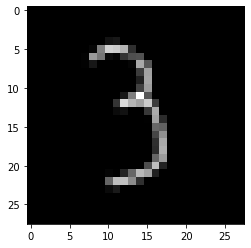

In [74]:
img = drawing_custom_number(preprocess=True,return_img=True)

In [76]:
test_input = torch.Tensor(np.array(img)).unsqueeze(0).to(device)
pred = model(test_input)
print("predicted number is {}.".format(pred.softmax(1).argmax().item()))

predicted number is 3.
